In [40]:
# --- Libraries ---
import math
from typing import Dict
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib import colors
import matplotlib.ticker as mticker
import squarify    
from pywaffle import Waffle
from matplotlib.cm import ScalarMappable
import geopandas as gpd
import cartopy.crs as ccrs
from highlight_text import fig_text
from pypalettes import create_cmap
from pyfonts import load_google_font
from matplotlib.lines import Line2D


In [41]:
# --- Data ---

# File names
BUILDING_EXPANSION_CSV: str = "../Data/Neubauwohnungen_2015-2024.csv"
BUILDING_STOCK_CSV: str     = "../Data/Bestand_Wohnungen_Zürich_2008-2024.csv"
TAXABLE_INCOME_CSV: str     = "../Data/Median-Einkommen-1999-2022.csv"
POPULATION_CSV: str         = "../Data/Bevölkerung_1999-2024.csv"

# GeoJSON for districts
KREISE_GEOJSON: str         = "../geo_data/kreise_zuerich.geojson"

In [42]:
# --- Column Mappings ---

# Column mapping for new residential buildings
BUILDING_EXPANSION_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "KreisSort": "district_name_sort",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_apartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "is_rental_apartment",
}

# Column mapping for housing stock by construction period
BUILDING_STOCK_COLMAP: Dict[str, str] = {
    "StichtagDatJahr": "year",
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "rooms_per_apartment",
    "AnzWhgStat": "num_apartments",
    "Wohnflaeche": "living_area",
}

# Column mapping for median taxable income
TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "KreisSort": "district_sort",
    "SteuerEinkommen_p50": "taxable_income_p50",
    "SteuerEinkommen_p25": "taxable_income_p25",
    "SteuerEinkommen_p75": "taxable_income_p75",
}

# Column mapping for population
POPULATION_COLMAP: Dict[str, str] = {
    "StichtagDatJahr": "year",
    "KreisSort": "district_sort",
    "AnzBestWir": "population_total",
}

In [43]:
# --- Function to load and rename CSV---------------------------------
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Load a CSV file and rename its columns according to the provided mapping."""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [44]:
# --- 3. Data Wrangling -----------------------------------------------
#
# This section prepares the analytical datasets used in the visualizations:
# - New buildings by district and five-year period,
# - Housing stock by record year and by building period,
# - District-level taxable income,
# - Combined income–population–buildings data for the bubble chart.
# ---------------------------------------------------------------------


# 3.1 New Buildings by District / 5-Year Period ------------------------

def transform_building_expansion(csv_path: str = BUILDING_EXPANSION_CSV) -> pd.DataFrame:
    """
    Transform the new-building expansion dataset into a district-level panel
    aggregated by five-year period.

    The input file contains information on newly built apartments (or buildings)
    at a more granular level. This function:

    1. Loads and renames the raw columns using BUILDING_EXPANSION_COLMAP.
    2. Aggregates units, floor area, and population-related counts to the level
       of (district_name, district_name_sort, five_year_period).
    3. Computes the number of rental apartments by counting rows where the
       indicator 'is_rental_apartment' equals 1.

    Parameters
    ----------
    csv_path : str, optional
        Path to the CSV file containing the raw expansion data.
        Defaults to BUILDING_EXPANSION_CSV.

    Returns
    -------
    pd.DataFrame
        A long-format DataFrame with one row per
        (district_name, district_name_sort, five_year_period) and the columns:
        - district_name : str
        - district_name_sort : int
        - five_year_period : str
        - num_retirees : float
        - num_children : float
        - living_area : float
        - num_rooms : float
        - num_apartments : float
        - population_total : float
        - rental_apartments : int
    """
    df = load_and_rename(csv_path, BUILDING_EXPANSION_COLMAP)

    aggregated = (
        df.groupby(["district_name", "district_name_sort", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_apartments=("num_apartments", "sum"),
              population_total=("population_total", "sum"),
              rental_apartments=("is_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )
    return aggregated


# 3.3 Housing Stock by Building Record Year ----------------------------

def transform_building_stock_by_record_year(csv_path: str = BUILDING_STOCK_CSV) -> pd.DataFrame:
    """
    Aggregate housing stock information by district and record year.

    The raw building stock dataset contains, for each district, the number
    of apartments by room category and the total living area. This function:

    1. Loads and renames the raw file using BUILDING_STOCK_COLMAP.
    2. Derives the total number of rooms by multiplying rooms_per_apartment
       by the number of apartments.
    3. Aggregates to the level of (district_name, district_sort, year),
       summing room counts, apartments, and living area.

    This transformed dataset is used, among other things, for:
    - computing yearly housing stock for the map visualizations,
    - combining housing information with income and population for the bubble chart.

    Parameters
    ----------
    csv_path : str, optional
        Path to the CSV file containing the building stock data.
        Defaults to BUILDING_STOCK_CSV.

    Returns
    -------
    pd.DataFrame
        A DataFrame with one row per (district_name, district_sort, year) and:
        - num_rooms : float (total number of rooms across all apartments)
        - num_apartments : float (total number of apartments)
        - living_area : float (total living area)
    """
    # The initial read is not strictly necessary but kept for clarity
    df = pd.read_csv(csv_path)
    df = load_and_rename(csv_path, BUILDING_STOCK_COLMAP)

    # Total number of rooms = category rooms per apartment * number of apartments
    df["num_rooms_total"] = df["rooms_per_apartment"] * df["num_apartments"]

    # Aggregation by district & record year
    df = (
        df.groupby(["district_name", "district_sort", "year"])
          .agg(
              num_rooms=("num_rooms_total", "sum"),
              num_apartments=("num_apartments", "sum"),
              living_area=("living_area", "sum"),
          )
          .reset_index()
    )
    return df


# 3.2 Income by District (Annual; used for 2015–2019 average etc.) -----

def transform_taxable_income(csv_path: str = TAXABLE_INCOME_CSV) -> pd.DataFrame:
    """
    Transform district-level taxable income data into a yearly panel.

    The raw dataset provides taxable income statistics by district and year.
    This function:

    1. Loads and renames the raw columns using TAXABLE_INCOME_COLMAP.
    2. Aggregates to (district_name, district_sort, year) by averaging
       the median taxable income values supplied in the source.
    3. Converts the median from thousands of CHF to absolute CHF by
       multiplying by 1,000.

    Parameters
    ----------
    csv_path : str, optional
        Path to the CSV file with the taxable income data.
        Defaults to TAXABLE_INCOME_CSV.

    Returns
    -------
    pd.DataFrame
        A DataFrame with:
        - district_name : str
        - district_sort : int
        - year : int
        - median_taxable_income : float (median taxable income in CHF)
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)

    aggregated = (
        df.groupby(["district_name", "district_sort", "year"])
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )

    # Convert from thousands of CHF to absolute CHF
    aggregated["median_taxable_income"] = aggregated["median_taxable_income"] * 1000
    return aggregated


# 3.3 Housing Stock by Building Period (Year 2024 only) ----------------

def transform_building_stock_by_building_period_2024(
    csv_path: str = BUILDING_STOCK_CSV,
) -> pd.DataFrame:
    """
    Aggregate housing stock information by district and building period
    for the record year 2024, and derive standardized indicators.

    This function is designed for the line-plot visualization that compares
    z-scores of:

    - rooms per apartment, and
    - living area per apartment

    across building periods within each district.

    Steps:
    1. Load and rename the building stock data (BUILDING_STOCK_COLMAP).
    2. Filter the dataset to year == 2024.
    3. Compute total rooms per group as rooms_per_apartment * num_apartments.
    4. Aggregate by (district_name, district_sort, building_period, building_period_sort),
       summing rooms, apartments, and living area.
    5. Compute:
       - area_per_apartment = living_area / num_apartments
       - rooms_per_apartment = num_rooms / num_apartments
    6. Within each district, standardize both ratios using z-scores.

    Parameters
    ----------
    csv_path : str, optional
        Path to the CSV file with housing stock records.
        Defaults to BUILDING_STOCK_CSV.

    Returns
    -------
    pd.DataFrame
        A DataFrame with one row per
        (district_name, district_sort, building_period, building_period_sort)
        and the following columns:
        - num_rooms : float
        - num_apartments : float
        - living_area : float
        - area_per_apartment : float
        - rooms_per_apartment : float
        - rooms_z : float (z-score within district)
        - area_z : float (z-score within district)
    """
    # Raw read (kept for symmetry); then renamed
    df = pd.read_csv(csv_path)
    df = load_and_rename(csv_path, BUILDING_STOCK_COLMAP)

    # Restrict to the record year used in the line plot
    df = df[df["year"] == 2024]

    # Total number of rooms = category rooms per apartment * number of apartments
    df["num_rooms_total"] = df["rooms_per_apartment"] * df["num_apartments"]

    # Aggregation by district & building period
    df = (
        df.groupby(
            ["district_name", "district_sort", "building_period", "building_period_sort"]
        )
        .agg(
            num_rooms=("num_rooms_total", "sum"),
            num_apartments=("num_apartments", "sum"),
            living_area=("living_area", "sum"),
        )
        .reset_index()
    )

    # Ratios at the district–building period level
    df["area_per_apartment"] = df["living_area"] / df["num_apartments"]
    df["rooms_per_apartment"] = df["num_rooms"] / df["num_apartments"]

    # Within-district standardization (z-scores) for line-plot comparison
    df["rooms_z"] = df.groupby("district_name")["rooms_per_apartment"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    df["area_z"] = df.groupby("district_name")["area_per_apartment"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    return df


# 3.4 Bubble Plot Data: Population + Income + Buildings ----------------

def transform_income_population_buildings() -> pd.DataFrame:
    """
    Construct the combined dataset used for the income–population–buildings
    bubble chart.

    This function merges three prepared datasets:
    - taxable income by district and year,
    - population by district and year,
    - housing stock by district and record year.

    Steps:
    1. Transform income data using `transform_taxable_income()`.
    2. Load and rename the population dataset using POPULATION_COLMAP.
    3. Transform building stock by record year using
       `transform_building_stock_by_record_year()`.
    4. Extract yearly district-level apartment counts from the buildings data.
    5. Inner-join population and income on (year, district_sort).
    6. Inner-join the result with apartment counts on (year, district_sort).

    The resulting DataFrame provides, for each district–year observation:
    - median taxable income,
    - total population,
    - number of apartments,

    which are then used as:
    - x (income),
    - y (population),
    - bubble size (apartments)

    in the bubble visualization.

    Returns
    -------
    pd.DataFrame
        A DataFrame with at least the following columns:
        - district_name : str (from population/income transforms)
        - district_sort : int
        - year : int
        - population_total : float
        - median_taxable_income : float (CHF)
        - num_apartments : float
    """
    income = transform_taxable_income()
    pop = load_and_rename(POPULATION_CSV, POPULATION_COLMAP)
    buildings = transform_building_stock_by_record_year()

    # Keep only the yearly apartment counts from the building stock
    buildings_year = buildings[["district_sort", "year", "num_apartments"]]

    # Combine population and income on year & district_sort
    pop_income = pd.merge(
        pop,
        income,
        on=["year", "district_sort"],
        how="inner",
    )

    # Add housing stock information (number of apartments)
    result = pd.merge(
        pop_income,
        buildings_year,
        how="inner",
        on=["year", "district_sort"],
    )

    return result


In [45]:
# 3.5 Data loading -----------------------------------------------------

building_expansion = transform_building_expansion()
taxable_income     = transform_taxable_income()
building_stock_record_year = transform_building_stock_by_record_year()
building_stock_building_period_2024 = transform_building_stock_by_building_period_2024()
building_income_population = transform_income_population_buildings()


In [46]:
# --- 4. Colors & Global Styling --------------------------------------

# central color palette
BLUE        = "#3D85F7"
BLUE_DARK = "#1A5FBF"
BLUE_LIGHT  = "#5490FF"
PINK        = "#C32E5A"
PINK_LIGHT  = "#D34068"
GREEN       = "#2E9E67"
GREEN_LIGHT = "#3FB77D"
GREY40      = "#666666"
GREY25      = "#404040"
GREY20      = "#333333"
BACKGROUND  = "#F5F4EF"
BLACK = "#000000"
WHITE = "#FFFFFF"


# Custom blue color gradient
cmap_blue = create_cmap(
    colors=[
        "#E8F1FF",
        "#C9E1FF",
        "#A7CEFF",
        "#7EB5FF",
        "#559BFF",
        "#2D7FE6",
        "#1A5FBF",
    ],
    cmap_type="continuous",
    name="BlueSoft",
)

# Extra fonts for maps & specialized plots
regular_font = load_google_font("Roboto")
bold_font    = load_google_font("Roboto", weight="bold")


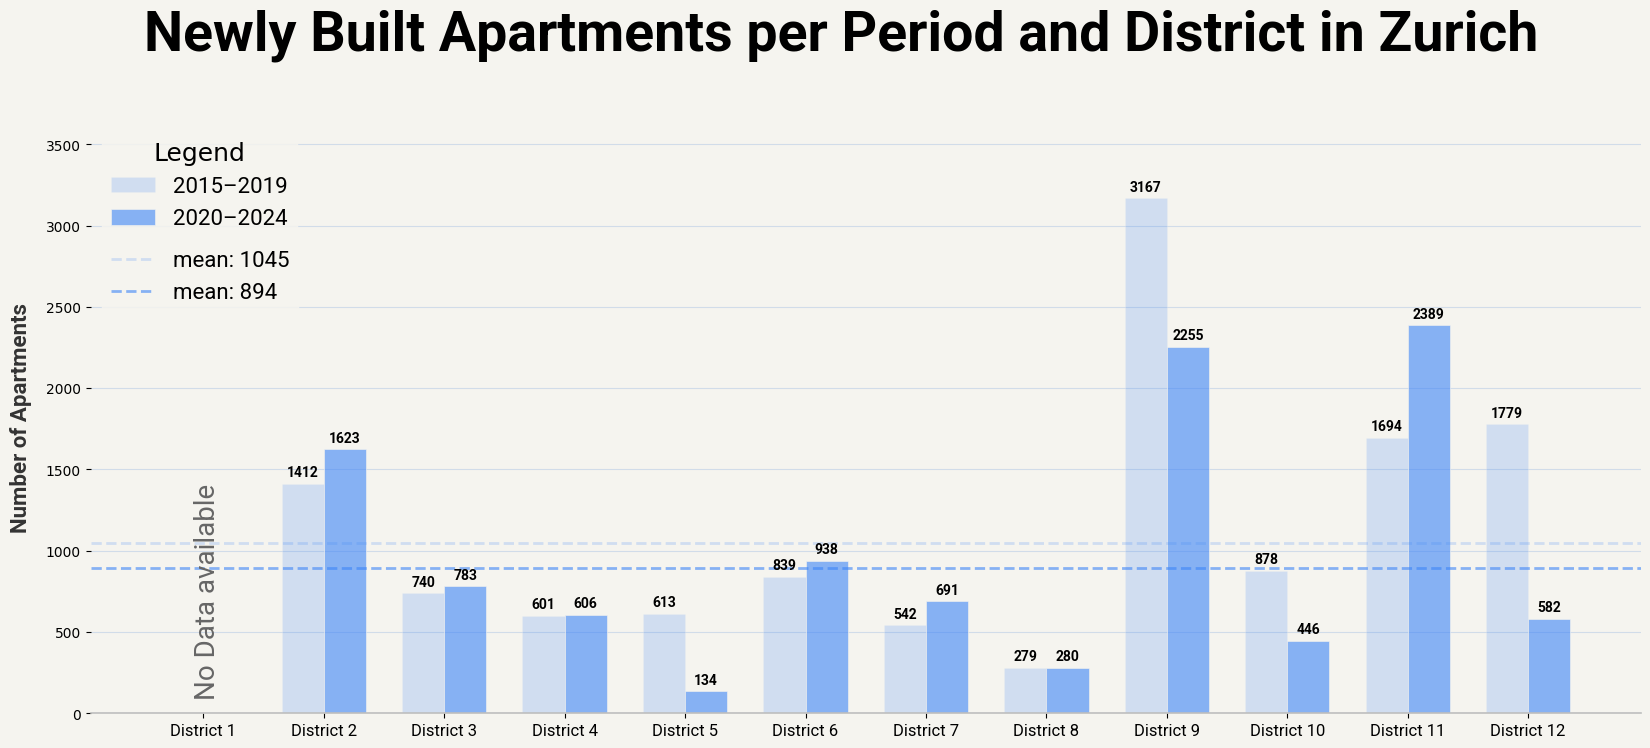

In [52]:
"""
This code visualizes the absolute growth of residential units in the city of Zurich
by district over two five-year periods (2015–2019 and 2020–2024).

In this version, only a single indicator is shown:
- the increase in the number of new apartments.

The result is one grouped bar chart with:
- two bars per district (one per five-year period),
- a legend for the periods (top-left),
- and a separate legend for the corresponding mean values (also top-left).

This focused layout highlights the spatial and temporal distribution of
new apartments while leaving sufficient space for axis labels, legends
and explanatory annotations.
"""

# ---------------- Data preparation ----------------
"""
Two five-year periods are selected for comparison:
- 2015–2019
- 2020–2024

Both periods are retained in the dataset so that each district can be
shown with two bars side by side, one for each period.
"""
periods = ["2015–2019", "2020–2024"]

df = building_expansion.copy()

"""
The dataset is restricted to the selected five-year periods. This allows
the visualization to focus on these two phases of urban development and
ensures that all plotted values refer to one of these periods.
"""
df = df[df["five_year_period"].isin(periods)].copy()

"""
Only the variables needed for the visualization are retained:
- district_name: name of the district (e.g. "Kreis 1"),
- living_area: increase in total living area (e.g. in m²),
- num_apartments: increase in the number of apartments,
- population_total: increase in the total population,
- five_year_period: the five-year period to which the values refer.

Missing values are dropped to avoid plotting incomplete data.
"""
df = df[
    ["district_name", "living_area", "num_apartments", "population_total", "five_year_period"]
].dropna().copy()

"""
A numerical district identifier is extracted from the district name.
This allows the districts to be sorted numerically (1, 2, 3, ...) rather than
alphabetically, which is more meaningful in the Zurich context.
"""
df["district_nr"] = df["district_name"].str.extract(r"(\d+)").astype(int)

"""
A simplified district label in English is created in the form
"District 1", "District 2", etc. This is used as the x-axis category
to make the plot more accessible to an English-speaking audience.
"""
df["district_label"] = "District " + df["district_nr"].astype(str)

"""
Districts are sorted by their numeric index to produce a coherent spatial
ordering in the bar chart, typically from District 1 to District 12.

The list `all_districts` defines the full set of district labels expected
in the plot, ensuring that districts with zero growth in a given period
are still shown with a bar of height zero.
"""
df = df.sort_values("district_nr")

all_districts = [f"District {i}" for i in range(1, 13)]
x_labels = all_districts

"""
Numeric x positions are used as the baseline for plotting district groups.
These positions are later combined with small offsets so that the bars for
different periods can be shown side by side within each district.
"""
x = np.arange(len(x_labels))

# ---------------- Layout & color configuration ----------------
"""
The single indicator visualized here is:
- the increase in the number of apartments.

The lists below are defined in the same pattern as for the multi-panel
version, but they contain only one entry each. This keeps the structure
flexible in case further indicators are added again in the future.
"""
colors_bars = [BLUE]
cols   = ["num_apartments"]
ylabs  = [
    "Number of Apartments",
]

"""
A figure with a single subplot is created.
This subplot corresponds to the growth in the number of apartments.

The vertical figure size is chosen to allow enough space for legends
and annotations below the main title.
"""
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
fig.patch.set_facecolor(BACKGROUND)
fig.suptitle(
    "Newly Built Apartments per Period and District in Zurich",
    fontsize=40,
    y=1.04,
    color="black",
    font=bold_font,
)

"""
A slightly larger font is used for legend text than for default labels
to improve readability when the legends contain multiple lines
(periods and their mean values).
"""
regular_font_legend = regular_font.copy()
regular_font_legend.set_size(16)


# ---------------- Single plot for the apartments indicator ----------------
"""
The following section constructs a grouped bar chart for the indicator
"num_apartments" (increase in the number of apartments) using:

- one growth variable (col),
- one base color (c),
- one subplot title, and
- one y-axis label.
"""
col = cols[0]
c = colors_bars[0]
ylab = ylabs[0]

"""
For the current indicator, a pivot table is constructed with:
- rows = district labels ("District 1", "District 2", ...),
- columns = five-year periods (2015–2019, 2020–2024),
whose cell values give the summed growth for each district-period combination.
Missing district-period combinations are filled with zero so that the
full district structure is always visible.
"""
tmp = df[["district_label", "five_year_period", col]]

pivot = tmp.pivot_table(
    index="district_label",
    columns="five_year_period",
    values=col,
    aggfunc="sum",
)

# ensure all districts 1–12 are present and in numeric order
pivot = pivot.reindex(all_districts)
pivot = pivot.fillna(0)

"""
To create grouped bars, we define:
- n_periods: number of five-year periods (here, 2),
- width: the width of each bar,
- offsets: horizontal shifts that place the bars side by side
  around the district group center.

For two periods, this results in one bar slightly left and one bar
slightly right of the x-position associated with each district.
"""
n_periods = len(periods)
width = 0.35
offsets = (np.arange(n_periods) - (n_periods - 1) / 2) * width

bar_containers = []
period_means = []   

"""
The following loop draws one bar series per period and at the same time
computes the mean value of that period across all districts. These means
are later visualized as dashed horizontal lines with their own legend.
"""
for i, p in enumerate(periods):
    y_vals = pivot[p].to_numpy()

    bars = ax.bar(
        x + offsets[i],
        y_vals,
        width=width,
        color=c,
        alpha=0.2 + 0.4 * i,   # later period slightly stronger
        edgecolor=BACKGROUND,
        linewidth=0.7,
        label=p,
    )
    bar_containers.append(bars)

    """
    The mean growth for the current period (across all districts) is computed.
    This single summary value is used to draw a dashed horizontal line and
    to create a corresponding entry in the mean legend.
    """
    mean_val_period = y_vals.mean()
    period_means.append((p, mean_val_period, 0.2 + 0.4 * i))

# --- Draw mean lines ---
"""
Dashed mean lines are added for each period. The alpha value of each line
matches the transparency of the corresponding bars, reinforcing the link
between period-specific bars and their mean.

The line handles and labels are collected to build a separate legend
that shows the mean values explicitly.
"""
mean_handles = []
mean_labels = []

for p, mean_val, alpha_val in period_means:
    h = ax.axhline(
        mean_val,
        color=c,
        linestyle="--",
        linewidth=2.0,
        alpha=alpha_val,
        zorder=1,
    )
    mean_handles.append(h)
    mean_labels.append(f"mean: {mean_val:.0f}")

"""
District labels are placed on the x-axis at the integer positions defined
by `x`. All districts from 1 to 12 are shown, including those with zero
growth in a given period.
"""
ax.set_xticks(x)
ax.set_xticklabels(x_labels,font=regular_font, fontsize=12)

"""
The subplot receives a descriptive title and an indicator-specific y-axis label.
"""
ax.set_ylabel(ylab, fontsize=16, font=bold_font, labelpad=10, color=GREY20)

"""
The y-axis limit is set slightly above the maximum observed value across
both periods to give the bar tops visual breathing space and to leave room
for labels and mean lines.
"""
max_val = np.nanmax(pivot.values)
ax.set_ylim(0, max_val * 1.15 if max_val > 0 else 1)

"""
Subplot styling:
- The background color is aligned with the overall theme.
- A horizontal grid on the y-axis is drawn behind the bars
  to aid in reading values without overpowering the visual.
- Most spines are removed to create a cleaner, more modern look,
  with only the bottom spine retained and slightly emphasized.
"""
ax.set_facecolor(BACKGROUND)
ax.set_axisbelow(True)
ax.grid(axis="y", color="#C9D7E8", linewidth=0.8, alpha=0.8)

for spine in ("top", "left", "right"):
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#BEBEBE")
ax.spines["bottom"].set_linewidth(1.2)

"""
Each bar is annotated with its numerical value. Zero-valued bars are left
unlabelled to avoid visual clutter, while non-zero values are written
directly above the bars. The labels are drawn with a higher z-order so
that they remain clearly visible even when crossing mean lines.
"""
for bc in bar_containers:
    labels = [f"{v:.0f}" if v != 0 else "" for v in bc.datavalues]
    ax.bar_label(
        bc,
        labels=labels,
        padding=3,
        fontsize=10,
        font=bold_font,
        zorder=5,     # labels clearly above the mean lines
    )

"""
Two separate legends are created:
- The first legend (period_legend) explains which bars correspond
  to which five-year period.
- The second legend (mean_legend) shows the mean lines and their
  corresponding numerical values.

Both legends are placed in the upper left of the subplot, with the
mean legend slightly shifted downward so that they do not overlap.
Their backgrounds are tinted with the figure background color to
ensure good contrast against the bars and grid.
"""
# --- LEGEND (periods) TOP-LEFT ---
period_legend = ax.legend(
    title="Legend",
    loc="upper left",
    title_fontsize=18,
    prop=regular_font_legend,
    frameon=True,
)

# style the legend background and frame
period_legend.get_frame().set_facecolor(BACKGROUND)
period_legend.get_frame().set_edgecolor(BACKGROUND)
period_legend.get_frame().set_alpha(0.85)

# --- SEPARATE MEAN LEGEND (also top-left, slightly shifted down) ---
mean_legend = ax.legend(
    mean_handles,
    mean_labels,
    loc="upper left",
    bbox_to_anchor=(0.00, 0.8155),
    prop=regular_font_legend,
    frameon=True,
)

mean_legend.get_frame().set_facecolor(BACKGROUND)
mean_legend.get_frame().set_edgecolor(BACKGROUND)
mean_legend.get_frame().set_alpha(0.85)

# ensure both legends are visible: re-add the period legend as an artist
ax.add_artist(period_legend)


"""
An explanatory text block is added below the plot. It provides a concrete,
interpretable example (District 3) to help the reader understand how
to read the visualized values in terms of apartments, living space and
population, even though this particular figure focuses on the number
of new apartments.
"""

fig.text(
    x=0.1765, y=0.185,
    s="No Data available",
    fontproperties=regular_font,
    fontsize=20,
    color=GREY40,
    ha="left",
    rotation=90,
)

"""
Some additional vertical space is reserved at the top and bottom for the
main title and explanatory text. The figure is saved to disk at high
resolution and then displayed on screen.
"""
plt.subplots_adjust(top=0.9, bottom=0.16)
fig.savefig("../Plots/Bar.png", dpi=300, bbox_inches="tight")
plt.show()


c:\Users\livio\Documents\FHNW\gdv\venv_gdv\Lib\site-packages\pywaffle\waffle.py:283: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  self.set_tight_layout(self.fig_args["tight"])
C:\Users\livio\AppData\Local\Temp\ipykernel_7380\234009130.py:166: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  fig.set_tight_layout(False)
C:\Users\livio\AppData\Local\Temp\ipykernel_7380\234009130.py:269: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_legend = ax.legend()
C:\Users\livio\AppData\Local\Temp\ipykernel_7380\234009130.py:269: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_legend = 

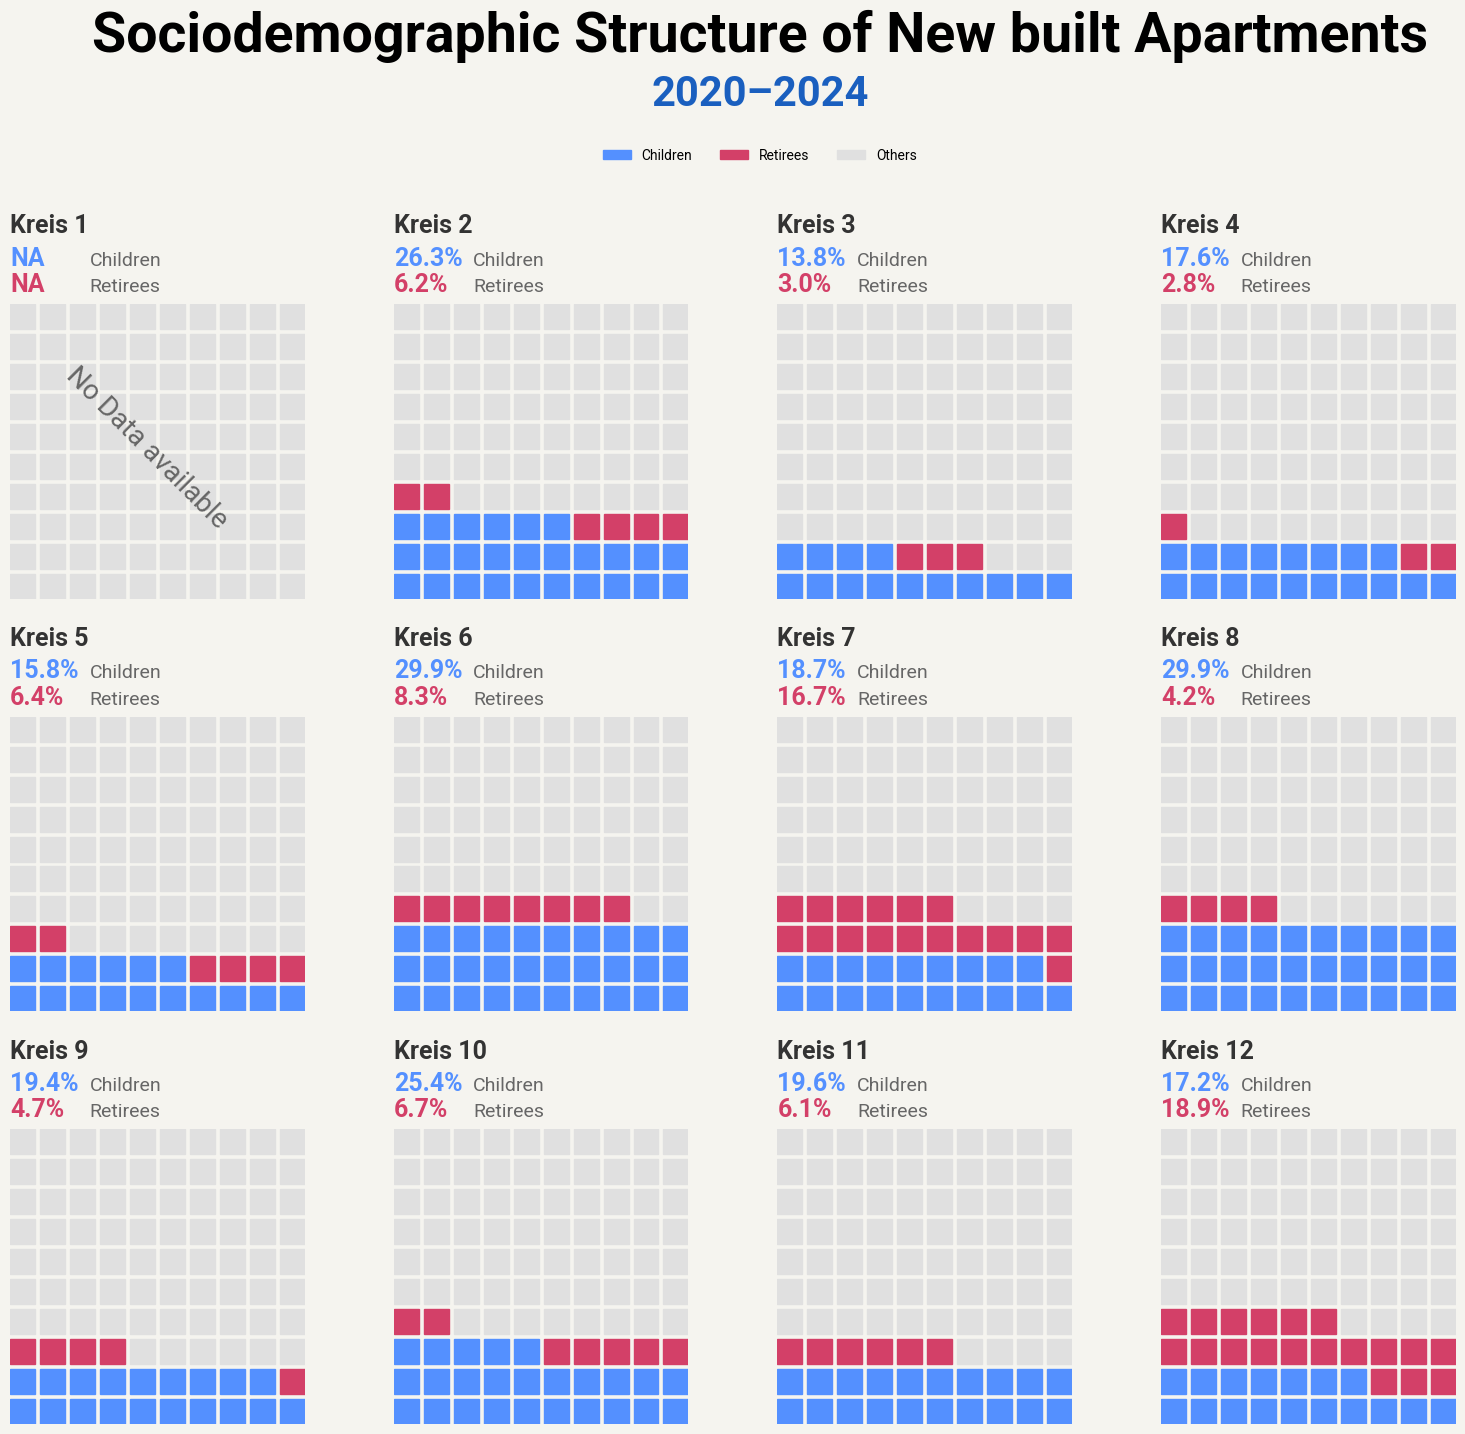

In [48]:
"""
This code visualizes the population structure in Zurich’s districts using
waffle charts for a specified five-year period. For each district, the total
population is broken down into three groups:

1. Children
2. Retirees
3. Others (remaining population)

Each district is represented by a small waffle chart, where the proportion of
colored squares corresponds to the relative size of these groups within the
district’s total population.

The figure is arranged as a grid of district panels, complemented by a global
title and a legend. For each district, summary statistics (percentages of
children and retirees) are displayed above the corresponding waffle chart.

The visualization is designed to highlight spatial variation in demographic
structure across districts within the same time period.
"""

# A fresh copy of the expansion dataset is created to avoid modifying the original.
df = building_expansion.copy()
period_of_interest = "2020–2024"

"""
The counts of children and retirees are cleaned by replacing missing values (NaN)
with zeros. This ensures that districts without recorded values for these groups
are treated as having zero members in that category, rather than being dropped
from the analysis.
"""
df["num_children"] = df["num_children"].fillna(0)
df["num_retirees"] = df["num_retirees"].fillna(0)

"""
The "other" population group is defined as the residual between the total population
and the sum of children and retirees. A lower bound of zero is enforced to avoid
negative counts, which could arise from inconsistencies or rounding issues in the data.
"""
df["other"] = (
    df["population_total"]
    - df["num_children"]
    - df["num_retirees"]
).clip(lower=0)

"""
Each district is assigned a numeric identifier extracted from its name (e.g. "Kreis 1" → 1).
This numeric key facilitates sorting the districts in a logical order that corresponds
to Zurich’s standard district numbering.
"""
df["kreis_num"] = (
    df["district_name"]
    .str.extract(r"(\d+)", expand=False)
    .astype(int)
)

"""
The DataFrame is sorted by this numeric district identifier, ensuring that
districts appear in a consistent spatial order across the figure.
"""
df = df.sort_values("kreis_num")

"""
The ordered list of district names is extracted and used to structure the waffle layout.
If "Kreis 1" is not present in the data (e.g. because no new apartments were built there),
it is manually inserted at the beginning of the list so that it appears in the figure
as a panel with no data.
"""
districts = list(df["district_name"].unique())

if "Kreis 1" not in districts:
    districts = ["Kreis 1"] + districts

"""
The three demographic groups are encoded with distinct colors:

- BLUE_LIGHT: Children
- PINK_LIGHT: Retirees
- "#E0E0E0": Others (remaining population)

These colors are reused consistently in both the waffle charts and the legend.
"""
colors_waffle = [BLUE_LIGHT, PINK_LIGHT, "#E0E0E0"]

"""
The `plots` dictionary stores the configuration entries for each district’s waffle chart.
Each entry contains the counts for children, retirees, and others for that district.
The `plot_index` keeps track of the panel index in the grid specification.
"""
plots = {}
plot_index = 1
n = len(districts)

"""
The number of columns in the subplot grid is fixed at four. The number of rows
is computed by rounding up the integer division of the number of districts by
the number of columns. This ensures that all districts fit into the grid.
"""
ncols = 4
nrows = math.ceil(n / ncols)

"""
A loop over all districts constructs the data for each waffle panel.
For each district, a dictionary of absolute counts for the three groups is created.
Districts with a total population of zero (sum of groups equals zero) are skipped,
as a waffle chart with no tiles would not be informative.

For "Kreis 1" specifically, a pseudo-panel with a single tile in the "Others"
category is created if the district does not exist in the data. This keeps
the layout structurally complete while still communicating that no data is
available for that district.
"""
for district in districts:

    # Special handling for "Kreis 1" when it is not present in the dataset
    if district == "Kreis 1" and district not in df["district_name"].values:
        # For the waffle chart, at least one tile is needed. A single dummy
        # tile is assigned to "Others". Summary percentages above the plot
        # remain at "NA" for this special case.
        values = {
            "Children": 0,
            "Retirees": 0,
            "Others": 1,  # dummy tile, purely for visualization
        }
        plots[(nrows, ncols, plot_index)] = {"values": values}
        plot_index += 1
        continue

    # Default case for districts that exist in the dataset
    row = df[df["district_name"] == district].iloc[0]
    values = {
        "Children": int(row["num_children"]),
        "Retirees": int(row["num_retirees"]),
        "Others": int(row["other"]),
    }
    if sum(values.values()) == 0:
        # Districts with a zero total population are skipped entirely
        continue

    # Each district’s values are stored under a subplot specification key.
    plots[(nrows, ncols, plot_index)] = {"values": values}
    plot_index += 1

"""
The waffle chart figure is created using the `Waffle` class. Each subplot is
configured based on the `plots` dictionary. The number of rows and columns
inside each waffle (here 10x10) determines the resolution of the tile grid,
i.e. how finely the population is discretized into squares.

Tiles are filled vertically from a starting position in the southwest corner
("SW"), resulting in a fully tiled 10x10 grid per district.
"""
fig = plt.figure(
    FigureClass=Waffle,
    plots=plots,
    rows=10,
    columns=10,
    colors=colors_waffle,
    vertical=True,
    starting_location="SW",
    figsize=(15, 14),
)

# The figure background is aligned with the overall theme.
fig.patch.set_facecolor(BACKGROUND)
fig.set_tight_layout(False)

"""
The subplot layout is adjusted to leave space for the global title, period label,
and legend at the top, while also maintaining adequate separation between the
individual waffle panels.
"""
fig.subplots_adjust(
    left=0,
    right=1,
    bottom=0.1,
    top=0.9,
    wspace=0.1,
    hspace=0.4,
)

"""
A global title communicates the main theme of the visualization:
the sociodemographic structure of new apartments by district.
The specific period of interest (e.g. 2020–2024) is displayed beneath
the title as an additional temporal qualifier.
"""
fig.suptitle(
    "Sociodemographic Structure of New built Apartments",
    fontproperties=bold_font,
    fontsize=40,
    color=BLACK,
    y=1.11,
)

fig.text(
    0.5, 1.05,
    f"{period_of_interest}",
    ha="center",
    va="center",
    fontsize=30,
    fontproperties=bold_font,
    color=BLUE_DARK,
)

"""
A custom legend is constructed using patches that match the waffle colors.
The legend is placed centrally above the grid of waffle charts, describing
which color corresponds to children, retirees, and other population.
"""
legend_handles = [
    Patch(color=colors_waffle[0], label="Children"),
    Patch(color=colors_waffle[1], label="Retirees"),
    Patch(color=colors_waffle[2], label="Others"),
]

fig.legend(
    handles=legend_handles,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),
    prop=regular_font,
    fontsize=18,
)

"""
Each waffle subplot is then annotated individually. For every axis corresponding
to a district, the district name and summary percentages for children and retirees
are placed above the waffle chart. These annotations combine categorical
and quantitative information in a compact header.
"""
for i, ax in enumerate(fig.axes):
    if i >= len(districts):
        break

    district_name = districts[i]

    """
    For "Kreis 1" without data in the underlying DataFrame, percentages are
    shown as "NA" to make the absence of data explicit. For all other districts,
    percentages are calculated relative to the total population in that district.
    """
    if district_name == "Kreis 1" and district_name not in df["district_name"].values:
        total = 0
        num_children = 0
        num_retirees = 0
        pct_kids_text = "NA"
        pct_ret_text  = "NA"
    else:
        row = df[df["district_name"] == district_name].iloc[0]
        total = row["population_total"]
        num_children = row["num_children"]
        num_retirees = row["num_retirees"]

        """
        The shares of children and retirees are expressed as percentages of the
        total district population. If the total population is zero, the percentage
        is defined as zero to avoid division by zero.
        """
        pct_kids = (num_children / total * 100) if total > 0 else 0
        pct_ret  = (num_retirees / total * 100) if total > 0 else 0

        pct_kids_text = f"{pct_kids:.1f}%"
        pct_ret_text  = f"{pct_ret:.1f}%"

    # Waffle automatically creates legends per subplot; these are removed
    # to avoid repetition and clutter, as a single global legend is used instead.
    ax_legend = ax.legend()
    if ax_legend is not None:
        ax_legend.remove()

    """
    The district name is written above the waffle in bold, followed by two
    lines indicating the percentages of children and retirees, each colored to
    match their waffle tiles. Descriptive text labels ("Children", "Retirees")
    accompany the percentages to clarify their meaning.
    """
    ax.text(
        x=0.0, y=1.24,
        s=district_name,
        fontproperties=bold_font,
        fontsize=18,
        color=GREY20,
        ha="left",
        transform=ax.transAxes,
    )

    ax.text(
        x=0.0, y=1.13,
        s=pct_kids_text,
        fontproperties=bold_font,
        fontsize=18,
        color=BLUE_LIGHT,
        ha="left",
        transform=ax.transAxes,
    )
    ax.text(
        x=0.27, y=1.13,
        s="Children",
        fontproperties=regular_font,
        fontsize=14,
        color="#666666",
        ha="left",
        transform=ax.transAxes,
    )

    ax.text(
        x=0.0, y=1.04,
        s=pct_ret_text,
        fontproperties=bold_font,
        fontsize=18,
        color=PINK_LIGHT,
        ha="left",
        transform=ax.transAxes,
    )
    ax.text(
        x=0.27, y=1.04,
        s="Retirees",
        fontproperties=regular_font,
        fontsize=14,
        color="#666666",
        ha="left",
        transform=ax.transAxes,
    )

"""
A diagonal annotation "No Data available" is added near the left side of the figure
to emphasize that some districts (such as Kreis 1) may not have recorded data for
the selected period. This complements the NA labels shown above those waffle charts.
"""
fig.text(
    x=0.034, y=0.74,
    s="No Data available",
    fontproperties=regular_font,
    fontsize=20,
    color=GREY40,
    ha="left",
    rotation=-45,
)

"""
Finally, the entire figure is saved as a high-resolution PNG file.
The tight bounding box option ensures that the exported image
includes the entire layout (title, legend, and annotations)
without excessive white margins.
"""
fig.savefig(
    "../Plots/Waffle.png",
    dpi=1000,
    bbox_inches="tight",
)

plt.show()


In [49]:
def plot_zurich_buildings_for_year(
    df,
    year,
    kreise_geojson_path=KREISE_GEOJSON,
    save_path=None,
):
    """
    This function constructs a composite visualization that combines a choropleth map and
    a small bar chart to describe the spatial distribution of residential apartments
    in the city of Zurich for a given reference year.

    The central element of the figure is a district-level map. Each district ("Kreis")
    is shaded according to the total number of apartments it contains in the specified
    year. The shading uses a continuous color scale, which allows differences in the
    magnitude of the indicator to be perceived at a glance.

    On top of the map, district-specific labels are added: the district name
    (renamed from "Kreis" to "District" for English readability) and the corresponding
    apartment count, formatted with thousands separators for clarity.

    A secondary visual element is a compact bar chart placed inside the same figure.
    The bar chart shows the same apartment-count values ordered by the district sort
    index, thereby complementing the geographic view with a simple, rank-like comparison.

    A mini KPI panel summarises the total number of apartments across all districts
    in the selected year, reinforcing an aggregate perspective.

    The overall layout is designed for compactness: map, KPI, colorbar, and bar chart
    are composed in a single figure.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format building stock dataset.
        - 'year' (int): the reference year of the observation
        - 'district_name' (str): the name of the district (e.g. "Kreis 1")
        - 'num_apartments' (int or float): count of apartments in the district
        - 'district_sort' (int): numeric ordering key for the districts
    year : int
        The year to be visualized (e.g. 2008, 2016, 2024).
    kreise_geojson_path : str
        File path to the GeoJSON dataset containing the geometries of Zurich's districts.
    save_path : str or None
        File path for saving the resulting PNG figure. If None is passed,
        a default path of the form "../Plots/Map_{year}.png" is used.
    """

    """
    For the selected year, a subset of the building stock dataset is created.
    This isolates the spatial distribution at a single point in time.
    If the filtered dataset is empty, the function stops with a descriptive error,
    as plotting an empty map would not be meaningful.
    """
    df_year = df[df["year"] == year].copy()
    if df_year.empty:
        raise ValueError(f"Kein Eintrag in df für year == {year}")

    # Only the relevant columns are retained to keep the merged structure concise.
    df_year = df_year[["district_name", "num_apartments", "district_sort"]]

    """
    The district geometries are read from a GeoJSON file.
    These geometries form the spatial backbone of the choropleth map.
    """
    gdf = gpd.read_file(kreise_geojson_path)

    """
    Building stock information is merged with the geographic layer.
    The join key is the district name: 'bezeichnung' (in the GeoJSON) and
    'district_name' (in the building stock data). An inner join is used
    to retain only those districts that exist in both datasets.
    """
    gdf_year = gdf.merge(
        df_year,
        left_on="bezeichnung",
        right_on="district_name",
        how="inner",
    )

    """
    For labeling, the German term "Kreis" is replaced with "District".
    The transformed name is stored in a separate column to keep the original intact.
    """
    gdf_year["district_name_label"] = gdf_year["district_name"].str.replace(
        "Kreis ", "District ", regex=False
    )

    """
    A Mercator projection is chosen as the map projection for the figure.
    While Zurich covers a relatively small area, using a proper map projection
    preserves geographic consistency and allows the use of cartopy's map features.
    """
    proj = ccrs.Mercator()

    """
    A single figure is created with one main axis for the map.
    The dpi is set reasonably high so that labels remain legible when embedded
    in documents. Axis-level settings are configured to hide the standard axes
    and frames, focusing attention on the geographic content.
    """
    fig, ax = plt.subplots(
        figsize=(6, 4),
        dpi=300,
        subplot_kw={"projection": proj},
    )

    fig.set_facecolor(BACKGROUND)
    ax.set_facecolor(BACKGROUND)
    ax.set_axis_off()

    """
    The title block communicates the spatial scope ("Apartments in Zurich City")
    and the reference year. The typographic emphasis is controlled by custom
    font properties.
    """
    fig_text(
        x=0.5, y=0.95,
        s="Apartments in Zurich City",
        color="black",
        fontsize=12,
        fontproperties=bold_font,
        ha="center", va="top",
        alpha=0.95,
    )

    fig_text(
        x=0.5, y=0.905,
        s=str(year),
        color="#1A5FBF",
        fontsize=8,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    """
    The core choropleth map is generated by plotting the district geometries
    with a color scale representing the number of apartments. A light stroke
    is added between districts to visually separate them.
    """
    gdf_year.plot(
        ax=ax,
        column="num_apartments",
        cmap=cmap_blue,
        linewidth=0.6,
        edgecolor="#ffffff",
    )

    """
    Label placement is handled via representative points inside each district polygon.
    Two vertical offsets are defined: one for the numeric value and one for the district name.
    This creates a compact two-line label anchored within each district.
    """
    LABEL_DY_VALUE = 0.0015
    LABEL_DY_NAME  = -0.0012

    """
    For each district, both the number of apartments (with thousands separators)
    and the district name are drawn. Minor manual adjustments are introduced for
    specific districts (4 and 5) to reduce label overlap in areas where districts
    are situated close to each other in the map.
    """
    for _, row in gdf_year.iterrows():
        rep = row.geometry.representative_point()
        x_coord, y_coord = rep.x, rep.y

        name = row["district_name_label"]
        num  = f"{row['num_apartments']:,}".replace(",", "'")

        x_num = x_coord
        x_name = x_coord

        # Manual horizontal tuning to avoid overlap in dense central districts
        if name in ["District 4", "District 5"]:
            x_num  = x_coord - 0.0015
            x_name = x_coord + 0.002

        # Numerical apartment count label
        ax.text(
            x_num, y_coord + LABEL_DY_VALUE,
            num,
            ha="center", va="center",
            fontproperties=regular_font,
            fontsize=4.5,
            color="black",
            alpha=0.95,
            zorder=10,
        )

        # District name label
        ax.text(
            x_name, y_coord + LABEL_DY_NAME,
            name,
            ha="center", va="center",
            fontproperties=regular_font,
            fontsize=3.5,
            color="black",
            alpha=0.75,
            zorder=10,
        )

    """
    The `thousands_formatter` helper converts large integers into strings
    with an apostrophe as the thousands separator (e.g. 12'345). This format
    is used consistently in labels and axes to improve numerical readability.
    """
    def thousands_formatter(x, pos):
        if x == 0:
            return "0"
        return f"{int(x):,}".replace(",", "'")

    """
    The total number of apartments across all districts in the selected year
    is computed and placed as a KPI at the bottom of the figure. This number
    anchors the visualization in an aggregate quantity, complementing the
    district-level breakdown.
    """
    total_buildings = int(gdf_year["num_apartments"].sum())
    kpi_str = thousands_formatter(total_buildings, None)

    fig_text(
        x=0.5, y=0.035,
        s=kpi_str,
        color="#1A5FBF",
        fontsize=12,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    fig_text(
        x=0.5, y=0.075,
        s="Total Apartments",
        color="black",
        fontsize=10,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    """
    A vertical colorbar is added as a legend for the choropleth.
    Its extent and normalization are derived from the minimum and maximum apartment
    counts in the dataset for the given year. The same thousands formatter is
    applied to the colorbar ticks for consistency with the map labels.
    """
    cax = fig.add_axes([0.3, 0.175, 0.01, 0.2])

    vmin = gdf_year["num_apartments"].min()
    vmax = gdf_year["num_apartments"].max()

    sm = ScalarMappable(
        cmap=cmap_blue,
        norm=colors.Normalize(vmin=vmin, vmax=vmax),
    )
    # Dummy assignment required for some Matplotlib versions before drawing the colorbar.
    sm._A = []

    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", pad=0.02)
    cbar.outline.set_edgecolor("black")
    cbar.ax.tick_params(labelsize=5, width=0.3, length=2, pad=1)
    cbar.outline.set_linewidth(0.3)
    cbar.outline.set_alpha(0.7)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

    # Colorbar tick labels adopt the regular font styling for visual coherence.
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_fontproperties(regular_font)
        lbl.set_fontsize(5)

    """
    In addition to the map, a compact bar chart is constructed to show the same
    apartment counts ordered by district index. This panel highlights relative
    differences between districts in a non-spatial manner, complementing the map.
    """
    bar_data = gdf_year.sort_values("district_sort")

    districts = bar_data["district_sort"].astype(str).values
    values = bar_data["num_apartments"].values

    norm = colors.Normalize(vmin=values.min(), vmax=values.max())
    bar_colors = [cmap_blue(norm(v)) for v in values]

    """
    The bar chart is positioned within the main figure using a manually specified
    axes rectangle. It uses the same color scale as the map to maintain a unified
    visual language between the two representations.
    """
    bar_ax = fig.add_axes([0.51, 0.185, 0.2, 0.1])
    bar_ax.set_facecolor("none")

    bars = bar_ax.bar(
        x=range(len(values)),
        height=values,
        color=bar_colors,
    )

    bar_ax.set_ylim(0, max(values) * 1.15)
    bar_ax.axhline(0, linewidth=0.3, color="#444444")

    """
    The x-axis of the bar chart is labeled with district sort indices.
    The font size is reduced to fit the compact layout. The y-axis uses the same
    thousands formatter as the map and colorbar, and is placed on the right side
    to visually align with the colorbar.
    """
    xtick_fp = regular_font.copy()
    xtick_fp.set_size(5)

    bar_ax.set_xticks(range(len(values)))
    bar_ax.set_xticklabels(districts, fontproperties=xtick_fp)

    bar_ax.set_xlabel(
        "District",
        fontproperties=regular_font,
        fontsize=6,
        labelpad=2,
        color="#1A5FBF",
    )

    bar_ax.tick_params(axis="x", width=0.3, pad=1)
    bar_ax.tick_params(axis="y", labelsize=4, pad=1, width=0.3)

    for lbl in bar_ax.get_yticklabels():
        lbl.set_fontproperties(regular_font)
        lbl.set_fontsize(5)

    bar_ax.yaxis.tick_right()
    bar_ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

    """
    The visual framing of the bar chart is kept minimal: only the bottom and right
    spines are retained, with thin, subtle lines. This keeps the chart readable
    without competing with the main map for attention.
    """
    for spine_name, spine in bar_ax.spines.items():
        if spine_name in ["bottom", "right"]:
            spine.set_visible(True)
            spine.set_linewidth(0.3)
            spine.set_edgecolor("#444444")
            spine.set_alpha(0.7)
        else:
            spine.set_visible(False)

    # A final layout adjustment reduces any remaining overlaps among elements.
    plt.tight_layout()

    """
    If no explicit save path is provided, a default filename that encodes the year
    is used. The figure is saved at high resolution and cropped to its content,
    making it ready for direct inclusion in academic or professional documents.
    """
    if save_path is None:
        save_path = f"../Plots/Map_{year}.png"

    plt.savefig(
        save_path,
        dpi=1000,
        bbox_inches="tight",
    )

    # The figure is closed to free up memory when creating multiple plots in sequence.
    plt.close(fig)


"""
The function above is applied to three selected years, generating a small temporal
series of static maps (2008, 2016, 2024). Together, these images can be used to
illustrate how the spatial distribution of apartments across Zurich's districts
has evolved over time.
"""
df = building_stock_record_year.copy()

plot_zurich_buildings_for_year(df, year=2008, save_path="../Plots/Map_2008.png")
plot_zurich_buildings_for_year(df, year=2016, save_path="../Plots/Map_2016.png")
plot_zurich_buildings_for_year(df, year=2024, save_path="../Plots/Map_2024.png")


C:\Users\livio\AppData\Local\Temp\ipykernel_7380\3362247484.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\livio\AppData\Local\Temp\ipykernel_7380\3362247484.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\livio\AppData\Local\Temp\ipykernel_7380\3362247484.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


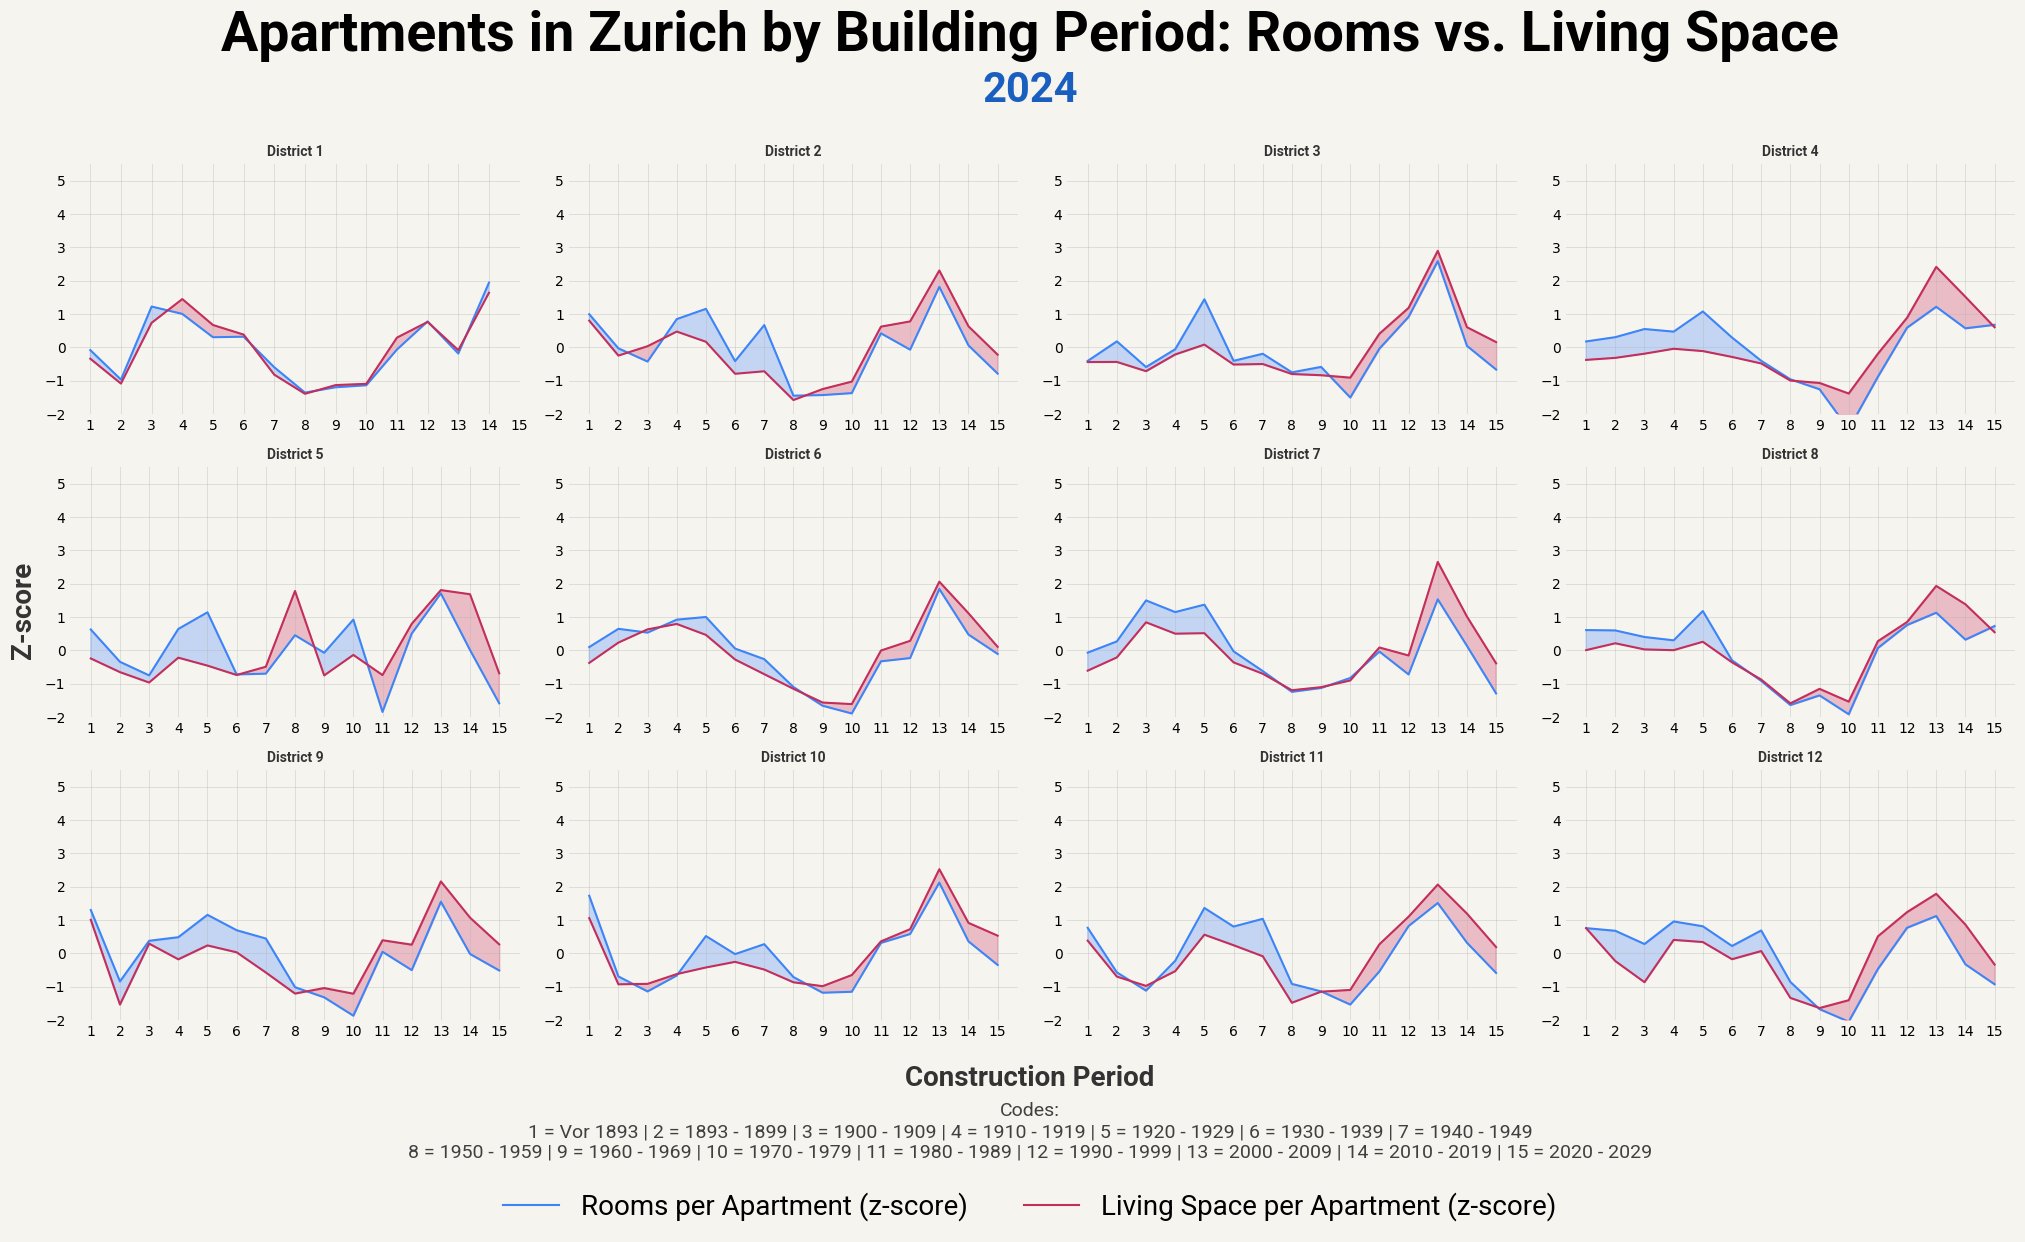

In [50]:
"""
This script visualises the apartment stock in 2024, focusing on the period in which
each apartment was built. For each district, two standardised indicators are plotted:

1. The average number of rooms per apartment, and
2. The average living area per apartment.

Both variables are expressed as z-scores to ensure comparability across periods and
districts.

Each district is represented in its own subplot, resulting in a multi-panel figure
that allows a direct visual comparison of temporal trends across the city. The
construction period is treated as the temporal axis and encoded by discrete numerical
categories. These categories are also mapped to their descriptive labels at the bottom
of the figure.

Shaded areas between the two curves highlight which variable dominates in a given
period: blue shading indicates that apartments had a disproportionately higher number
of rooms, while pink shading indicates that living area was relatively larger.

The figure is designed to emphasize cross-district differences while maintaining full
visual consistency across axes, scales, and layout.
"""

# A separate copy of the dataset is created to preserve the original object.
df_base = building_stock_building_period_2024.copy()

"""
Districts are sorted according to the numeric identifier contained in their name.
This yields a logically ordered sequence ("District 1", "District 2", ..., "District 12")
that corresponds to Zurich's official district numbering.
"""
df_base["district_name"] = (
    df_base["district_name"]
    .str.replace("Kreis", "District", regex=False)
)

districts_sorted = sorted(
    df_base["district_name"].unique(),
    key=lambda x: int(x.split()[-1])
)

"""
Construction-period codes are collected once for the entire city.
Using a globally consistent set of x-ticks ensures that all subplots share the same
temporal reference frame, which is essential for comparability.
"""
x_vals = np.sort(df_base["building_period_sort"].unique())

"""
A 3x4 grid of subplots is created, providing a dedicated panel for each district.
The figure size is chosen so that labels, titles, and line structures remain legible
despite the number of subplots.
"""
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

# Additional spacing between subplots improves visual separation of districts.
fig.subplots_adjust(hspace=0.35)

"""
Two invisible Line2D objects are created for the legend.
They serve as labeled color references for the z-scores of rooms and living area,
ensuring consistent legend entries without duplicating elements inside the subplots.
"""
line_rooms = plt.Line2D([], [], color=BLUE, label="Rooms per Apartment (z-score)")
line_area  = plt.Line2D([], [], color=PINK, label="Living Space per Apartment (z-score)")

"""
The core visualization loop: each district is plotted in its own subplot.
For every district, the dataset is filtered, sorted chronologically, and then rendered
as a pair of line graphs. The shared approach across subplots preserves analytical coherence.
"""
for ax, district in zip(axes, districts_sorted):

    # Extract time-sorted observations for the district
    df_district = (
        df_base[df_base["district_name"] == district]
        .sort_values("building_period_sort")
    )

    """
    Each subplot shows two trajectories over the construction periods:
    - rooms_z: standardized number of rooms per apartment
    - area_z: standardized living space per apartment

    The use of z-scores ensures that differences in scale between variables do not distort
    the visual comparison across districts and time periods.
    """
    x = df_district["building_period_sort"].values
    y_rooms = df_district["rooms_z"].values
    y_area  = df_district["area_z"].values

    # Line plots for both indicators
    ax.plot(x, y_rooms, color=BLUE)
    ax.plot(x, y_area,  color=PINK)

    """
    The filled area between the two curves highlights which indicator dominates
    in each time period. This technique supports visual interpretation by emphasizing
    the relative balance between room count and floor area:
    - blue shading signals higher room density,
    - pink shading signals relatively larger living space.
    """
    ax.fill_between(
        x, y_rooms, y_area,
        where=(y_rooms > y_area),
        interpolate=True,
        color=BLUE_LIGHT,
        alpha=0.3,
    )

    ax.fill_between(
        x, y_rooms, y_area,
        where=(y_rooms <= y_area),
        interpolate=True,
        color=PINK_LIGHT,
        alpha=0.3,
    )

    # All subplots use a common set of construction-period ticks
    ax.set_xticks(x_vals)

    """
    A uniform y-axis range is imposed across all districts to make visual
    comparison of levels and variation straightforward.
    """
    ax.set_ylim(-2, 5.5)

    """
    Visual styling:
    - A themed background color is applied,
    - All spines are removed for a cleaner look,
    - A light grid is added to support value reading without dominating the view,
    - Tick marks are hidden to reduce visual noise.
    """
    ax.set_facecolor(BACKGROUND)
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(which="both", lw=0.6, alpha=0.4)
    ax.tick_params(axis="both", length=0)

    # Each panel is labeled with the district it represents
    ax.set_title(district, font=bold_font, color=GREY20)

"""
If fewer districts exist than subplot slots, the remaining axes are hidden.
This avoids showing empty placeholders and keeps the figure aesthetically clean.
"""
for ax in axes[len(districts_sorted):]:
    ax.set_visible(False)

# Apply a shared background color to the entire figure.
fig.set_facecolor(BACKGROUND)

"""
Global figure labels provide overarching context:
- A main title describing the subject of analysis,
- A year marker,
- A global y-axis label for z-scores,
- A global x-axis label for construction periods.
"""
fig.text(
    0.5, 0.95,
    "Apartments in Zurich by Building Period: Rooms vs. Living Space",
    ha="center", va="top",
    fontsize=40, fontweight="bold", font=bold_font, color=BLACK,
)

fig.text(
    0.5, 0.9,
    "2024",
    ha="center", va="top",
    fontsize=30, fontweight="bold", font=bold_font, 
    color=BLUE_DARK,
)

fig.text(
    -0.01, 0.45, "Z-score",
    va="center", rotation="vertical",
    fontsize=20, fontweight="bold", font=bold_font, color=GREY20,
)

fig.text(
    0.5, 0.06, "Construction Period",
    ha="center", va="center",
    fontsize=20, fontweight="bold", font=bold_font, color=GREY20,
)

"""
To make the numerical construction-period codes interpretable,
a mapping table is created from the full dataset. The mapping is printed at the bottom
of the figure as a compact legend, split into two lines to save space.
"""
periods = (
    df_base[["building_period_sort", "building_period"]]
    .drop_duplicates()
    .sort_values("building_period_sort")
)

mapping_entries = [
    f"{int(row.building_period_sort)} = {row.building_period}"
    for _, row in periods.iterrows()
]

half = len(mapping_entries) // 2
line1 = " | ".join(mapping_entries[:half])
line2 = " | ".join(mapping_entries[half:])

fig.text(
    0.5, 0.015,
    f"Codes:\n{line1}\n{line2}",
    ha="center", va="center",
    fontsize=14,
    color=GREY25,
    font=regular_font,
)

"""
A centralized legend is placed beneath all subplots, representing the two z-score indicators.
This avoids redundancy within each subplot while preserving interpretability.
"""
regular_font_lines = regular_font.copy()
regular_font_lines.set_size(20)

fig.legend(
    handles=[line_rooms, line_area],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.08), 
    ncol=2,
    frameon=False,
    fontsize=20,
    prop=regular_font_lines,
)

"""
The layout is tightened to ensure that subplots, legend, and titles fit together harmoniously
without overlapping. Margins are reserved explicitly for the title area and the lower legend.
"""
plt.tight_layout(rect=[0, 0.08, 1, 0.85])

"""
The completed figure is exported as a high-resolution PNG. A high dpi value is chosen so that
labels and lines remain crisp when included in academic reports or presentations.
"""
fig.savefig(
    "../Plots/Line.png",
    dpi=1000,
    bbox_inches="tight",
)


C:\Users\livio\AppData\Local\Temp\ipykernel_7380\3585387842.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_kreise = cm.get_cmap("tab20", len(unique_kreise))


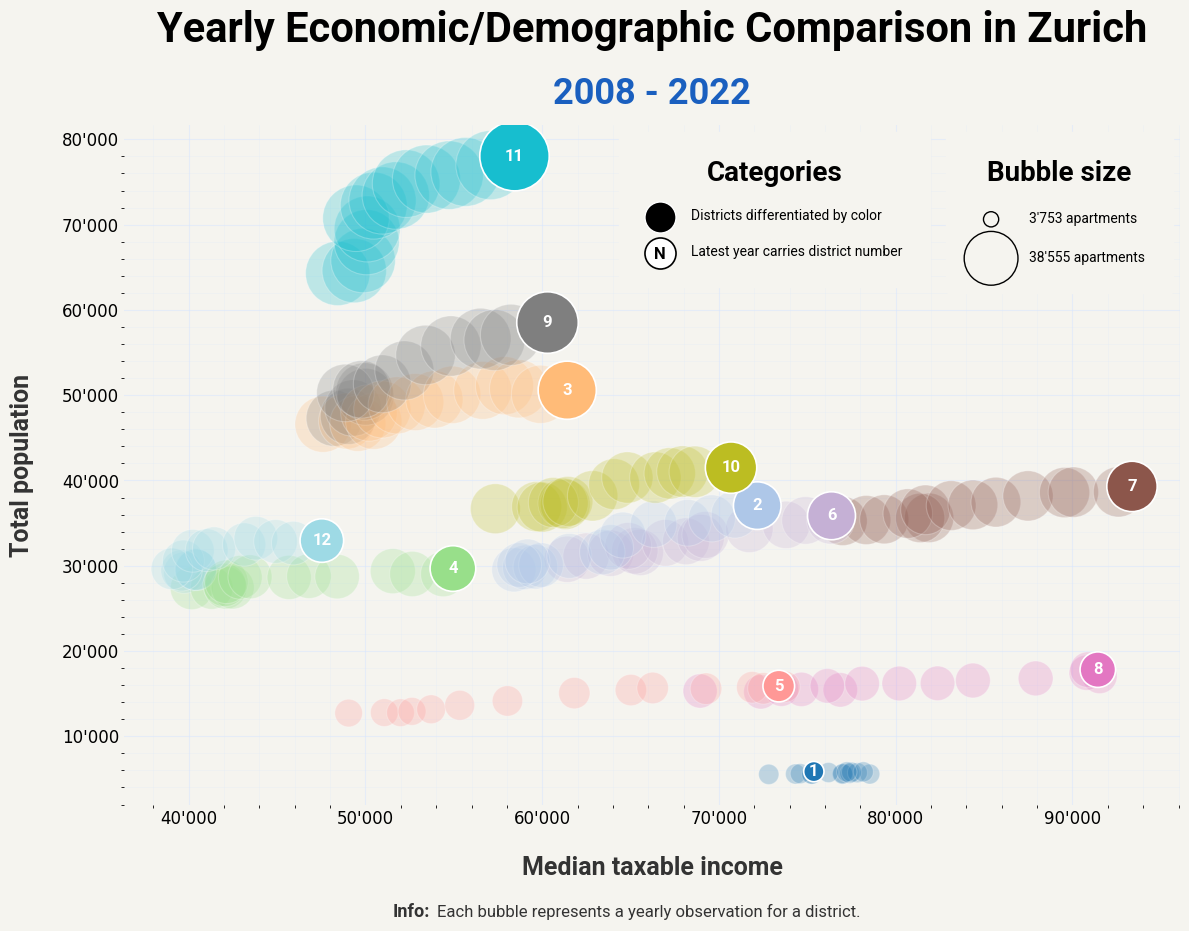

In [51]:
"""
This script visualizes the relationship between median taxable income and total population
for Zurich districts using a bubble chart. Each observation corresponds to a district–year
combination and is represented as a bubble in a two-dimensional space:

- x-axis: median taxable income
- y-axis: total population
- bubble size: number of apartments (proxy for housing stock or density)
- bubble color: district identity (constant across years for the same district)

To emphasize temporal development, all available years for each district are included,
but only the *latest* year per district is highlighted with fully opaque bubbles and
district labels. Older observations for each district are shown using the same color
but with increased transparency, creating a visual trajectory of the district's
position over time.

This design allows for the simultaneous exploration of:
1. Cross-sectional differences between districts (income, population, housing size),
2. Temporal changes in these characteristics, and
3. The interplay between income levels and demographic scale across districts.
"""

# ---------------- Data preparation ----------------
"""
A copy of the original dataset is created to avoid modifying it in place.
The year variable is explicitly cast to integer for clarity and consistency.
"""
df = building_income_population.copy()
df["year"] = df["year"].astype(int)

"""
The core variables used in the bubble chart are extracted:

- x_data: median taxable income per district–year observation,
- y_data: total population per district–year observation,
- size_data: number of apartments, which determines bubble size,
- kreis_data: numeric district sorting key (used to group and color-code districts).

These Series form the basis of the visual encodings in the plot.
"""
x_data      = df["median_taxable_income"]
y_data      = df["population_total"]
size_data   = df["num_apartments"].astype(float)
kreis_data  = df["district_sort"]


# ---------------- Layout & colors ----------------
"""
A single figure and axis are created for the bubble chart.
The background color of both the figure and the axis is set to a project-wide
theme color defined as BACKGROUND.
"""
fig, ax = plt.subplots(figsize=(12, 9))
fig.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)


# ---------------- Bubble size mapping ----------------
"""
Bubble sizes are derived from the number of apartments in each observation.
To make size differences visually meaningful, a linear scaling is applied
between a minimum and maximum marker size.

Special handling is included for cases where:
- all size_data values are identical (or effectively identical), or
- only a single unique value exists.

In such cases, all bubbles are assigned the same size to avoid division by zero
and to keep the visual representation stable.
"""
s_min = size_data.min()
s_max = size_data.max()

if size_data.nunique() <= 1 or s_max == s_min:
    # All bubbles share a uniform size if no variation exists
    sizes = np.full_like(size_data, 800.0)
else:
    # Linear scaling from a base size (200) to a maximum size (2500)
    sizes = 200 + (size_data - s_min) / (s_max - s_min) * (2500 - 200)


# ---------------- Color mapping by district ----------------
"""
Each district is assigned a distinct color, which is kept constant across years.
The 'tab20' colormap is used to generate a palette with one color per district.

The mapping is done via an integer encoding of district_sort:
    district_sort → index → colormap color

This allows bubbles belonging to the same district to be visually grouped, even
when multiple years are shown.
"""
unique_kreise = sorted(kreis_data.unique())
kreis_to_int = {k: i for i, k in enumerate(unique_kreise)}
cmap_kreise = cm.get_cmap("tab20", len(unique_kreise))
colors_by_kreis = kreis_data.map(kreis_to_int)


# ---------------- Identify latest year per district ----------------
"""
For each district, the latest year available in the dataset is identified.
A boolean mask 'is_latest' marks rows corresponding to these most recent
observations.

These will be emphasized in the visualization (opaque bubbles and labels),
while older years remain as semi-transparent background context.
"""
is_latest = df.groupby("district_sort")["year"].transform(
    lambda s: s == s.max()
)


# ---------------- Scatter plot: older years ----------------
"""
Older observations (non-latest year per district) are plotted first with
semi-transparent bubbles. This positions them visually behind the more recent
data, while still conveying historical information about each district’s
income and population trajectory.
"""
ax.scatter(
    x_data[~is_latest],
    y_data[~is_latest],
    s=sizes[~is_latest],
    c=colors_by_kreis[~is_latest],
    cmap=cmap_kreise,
    alpha=0.25,
    edgecolor="white",
    linewidth=0.8,
    zorder=2,
)


# ---------------- Scatter plot: latest year ----------------
"""
The latest year per district is plotted on top with fully opaque bubbles.
These bubbles represent the current or most recent position of each district
in the income–population space.

A slightly thicker white edge is used to visually distinguish them from
older points and to enhance their prominence against the background.
"""
ax.scatter(
    x_data[is_latest],
    y_data[is_latest],
    s=sizes[is_latest],
    c=colors_by_kreis[is_latest],
    cmap=cmap_kreise,
    alpha=1.0,
    edgecolor="white",
    linewidth=1.2,
    zorder=4,
)


# ---------------- Labels for latest-year bubbles ----------------
"""
Each bubble corresponding to the latest year per district is annotated with
the district sort number (e.g. 1, 2, 3, ...). The labels are centered on top
of the bubbles and rendered in bold white text, making them readable even
against darker bubble colors.
"""
df_latest = df[is_latest]
for _, row in df_latest.iterrows():
    ax.text(
        row["median_taxable_income"],
        row["population_total"],
        s=str(int(row["district_sort"])),
        ha="center",
        va="center",
        fontsize=12,
        font=bold_font,
        color=WHITE,
        zorder=6,
    )


# ---------------- Axes labels, title, and subtitle ----------------
"""
The y-axis and x-axis tick labels are formatted using a thousands-separator
function, which converts large integers into strings with apostrophes as
separators (e.g. 12345 → "12'345") to improve readability.
"""
def thousands(x, pos):
    try:
        return f"{int(x):,}".replace(",", "'")
    except (ValueError, TypeError):
        return ""

"""
A descriptive main title and a concise subtitle are added to the plot.
The subtitle indicates the full range of years covered in the dataset,
reinforcing the temporal context for the viewer.
"""
bold_font_title = bold_font.copy()
bold_font_title.set_size(30)

ax.set_title(
    "Yearly Economic/Demographic Comparison in Zurich",
    color=BLACK,
    pad=60,
    font=bold_font_title,
    position=(0.5, 1.2),
)

year_min = df["year"].min()
year_max = df["year"].max()

ax.text(
    0.5, 1.02,
    f"{year_min} - {year_max}",
    ha="center",
    va="bottom",
    transform=ax.transAxes,
    fontsize=26,
    font=bold_font,
    color=BLUE_DARK,
)

"""
Axis labels define the two main dimensions of the bubble chart:
income and population. Their styling is aligned with the general
visual theme of the project.
"""
ax.set_xlabel(
    "Median taxable income",
    fontsize=18,
    font=bold_font,
    color=GREY20,
    labelpad=20,
)
ax.set_ylabel(
    "Total population",
    fontsize=18,
    labelpad=20,
    font=bold_font,
    color=GREY20,
)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(thousands))

# Tick appearance is simplified by removing tick marks and adjusting label size.
ax.tick_params(axis="both", length=0, colors="black", labelsize=12)


# ---------------- Grid & spines ----------------
"""
Minor ticks are enabled to support the minor grid. Both major and minor gridlines
are drawn in a light blue shade to guide the eye without overpowering the data.
All axis spines are hidden to keep the focus on the bubbles.
"""
ax.minorticks_on()
ax.grid(which="major", lw=0.8, alpha=0.5, color="#D6E6FF")
ax.grid(which="minor", lw=0.4, alpha=0.3, color="#D6E6FF")

for spine in ax.spines.values():
    spine.set_visible(False)


# ---------------- Legend for bubble sizes ----------------
"""
A separate legend is constructed to explain the meaning of bubble sizes.
To avoid clutter, only a small set of representative sizes is selected:

- the smallest non-zero number of apartments,
- the largest non-zero number of apartments.

If only a single non-zero value exists, the legend uses just one reference size.
Marker sizes in the legend are scaled down compared to the actual plot for
better integration in the figure layout.
"""
valid_sizes = size_data[size_data > 0]

if len(valid_sizes) > 0:
    s_min_nonzero = valid_sizes.min()
    s_max_nonzero = valid_sizes.max()

    # If there is effectively no variation, only one reference value is displayed.
    if np.isclose(s_min_nonzero, s_max_nonzero):
        size_raw = np.array([s_min_nonzero])
    else:
        size_raw = np.array([s_min_nonzero, s_max_nonzero])

    if s_max == s_min:
        marker_sizes = np.array([800.0]) * 0.6
    else:
        marker_sizes = 200 + (size_raw - s_min) / (s_max - s_min) * (2500 - 200)
        marker_sizes = marker_sizes * 0.6

# Handles for bubble size legend
size_handles = [
    plt.scatter(
        [], [],
        s=ms,
        facecolor="none",
        edgecolor="black",
        linewidth=1.0,
    )
    for ms in marker_sizes
]

size_labels = [
    f"{int(round(v)):,}".replace(",", "'") + " apartments"
    for v in size_raw
]

"""
Legend 1 (bubble size) explains how the marker area scales with the number
of apartments. It is placed in the upper-right corner of the plot.
"""
leg_size = ax.legend(
    handles=size_handles,
    labels=size_labels,
    title="Bubble size",
    fontsize=12,
    title_fontsize=14,
    prop=regular_font,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor=BACKGROUND,
    edgecolor=BACKGROUND,
    framealpha=1.0,
    borderpad=2,
    labelspacing=1.8,
    handlelength=2.5,
    handletextpad=1.5,
)

bold_font_bubble_title = bold_font.copy()
bold_font_bubble_title.set_size(20)
leg_size.get_title().set_fontproperties(bold_font_bubble_title)

"""
Legend 2 (categories) clarifies how color and labeling are used:
- colors differentiate districts,
- and the latest-year bubbles carry district numbers.
"""
handle_district = plt.scatter(
    [], [],
    s=500,
    facecolor="black",
    edgecolor="white",
    linewidth=1.0,
)

handle_latest = plt.scatter(
    [], [],
    s=500,
    facecolor="white",
    edgecolor="black",
    linewidth=1.2,
)

extra_labels = [
    "Districts differentiated by color",
    "Latest year carries district number",
]

leg_extra = ax.legend(
    handles=[handle_district, handle_latest],
    labels=extra_labels,
    title="Categories",
    fontsize=12,
    title_fontsize=14,
    prop=regular_font,
    loc="upper right",
    bbox_to_anchor=(0.77, 1),
    frameon=True,
    facecolor=BACKGROUND,
    edgecolor=BACKGROUND,
    framealpha=1.0,
    borderpad=2,
    labelspacing=1.6,
    handlelength=2.0,
    handletextpad=1.2,
)

bold_font_extra_title = bold_font.copy()
bold_font_extra_title.set_size(20)
leg_extra.get_title().set_fontproperties(bold_font_extra_title)

# Ensure both legends are visible: re-add the size legend as an artist
ax.add_artist(leg_size)

"""
A small "N" annotation is added in the figure space to indicate that the
bubble size legend refers to sample size (number of apartments).
"""
ax.text(
    0.5542, 0.712,
    "N",
    fontsize=12,
    font=bold_font,
    color="black",
    transform=fig.transFigure,
    ha="center",
    va="center",
    zorder=10,
)

"""
Explanatory text at the bottom of the figure explains what each bubble represents
and provides a brief "Info" label for emphasis.
"""
fig.text(
    0.545, -0.019,
    "Each bubble represents a yearly observation for a district.",
    ha="center",
    va="center",
    fontsize=12,
    font=regular_font,
    color=GREY20,
)

fig.text(
    0.347, -0.019,
    "Info:",
    ha="center",
    va="center",
    fontsize=13,
    font=bold_font,
    color=GREY20,
)

"""
A tight layout is applied to reduce overlapping of labels, legend, and axes,
making the final figure more compact and publication-ready.
"""
plt.tight_layout()

fig.savefig("../Plots/Bubble.png", dpi=300, bbox_inches="tight")

plt.show()
